In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [284]:
import re
import ast
import nltk
import random
import numpy as np
import pandas as pd
from random import randint
import matplotlib.cm as cm
from fuzzywuzzy import fuzz
from sklearn.svm import SVC
from nltk import word_tokenize
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from flask import Flask, request
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer
from scipy.spatial.distance import cosine
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

# Data Preprocessing

In [7]:
def cleaned_text(raw_text):
    raw_text = re.findall(r"[a-zA-Z]+", raw_text)
    raw_text = " ".join(raw_text).lower()
    tokens = word_tokenize(raw_text)
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return " ".join(tokens)

In [11]:
#loading dataset and removing unwanted features
dataset = pd.read_csv(f'Book_summary.csv', encoding= 'unicode_escape')
dataset = dataset.drop('Publication Date', axis=1)
dataset = dataset.drop('Wikibedia ID', axis=1)
dataset = dataset.drop('Freebase ID', axis=1)
dataset

,Book title,Book author,Genre,Summary
0,Animal Farm,George Orwell,"{""/m/016lj8"": ""Roman à clef"", ""/m/06nbt"": ""Sat...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,NaN,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...
16554,Under Wildwood,Colin Meloy,NaN,"Prue McKeel, having rescued her brother from ..."
16555,Transfer of Power,Vince Flynn,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,Decoded,Jay-Z,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,NaN,Colbert addresses topics including Wall Stree...


In [12]:
#check for nulls and removing nans
dataset.isnull().count()
dataset = dataset.dropna(axis = 0)
dataset = dataset.reset_index(drop=True)

In [13]:
for ind, item in dataset.iterrows():
    item["Genre"] = frozenset(list(ast.literal_eval(item["Genre"]).values()))
    item['Summary'] = cleaned_text(str(item['Summary']))

In [14]:
dataset

,Book title,Book author,Genre,Summary
0,Animal Farm,George Orwell,"(Satire, Fiction, Children's literature, Specu...",old major old boar manor farm call animal farm...
1,A Clockwork Orange,Anthony Burgess,"(Utopian and dystopian fiction, Satire, Novell...",alex teenager living near future england lead ...
2,The Plague,Albert Camus,"(Fiction, Existentialism, Novel, Absurdist fic...",text plague divided five part town oran thousa...
3,A Fire Upon the Deep,Vernor Vinge,"(Speculative fiction, Hard science fiction, Fi...",novel posit space around milky way divided con...
4,All Quiet on the Western Front,Erich Maria Remarque,"(War novel, Roman à clef)",book tell story paul b umer german soldier urg...
...,...,...,...,...
12050,The Third Lynx,Timothy Zahn,(Science Fiction),story start former government agent frank comp...
12051,Remote Control,Andy McNab,"(Thriller, Fiction, Suspense)",series follows character nick stone ex militar...
12052,Transfer of Power,Vince Flynn,"(Thriller, Fiction)",reader first meet rapp covert operation iran d...
12053,Decoded,Jay-Z,(Autobiography),book follows rough chronological order switchi...


# Feature Engineering

## TF-IDF

In [15]:
tfIdf_vectorizer = TfidfVectorizer(use_idf=True, min_df=0.05)

tfidf_model = tfIdf_vectorizer.fit_transform(dataset['Summary'])
tfidf_features = pd.DataFrame(tfidf_model.toarray(), columns = tfIdf_vectorizer.get_feature_names())

In [40]:
# tfidf_features_reduced = TSNE(n_components=2, perplexity=40, learning_rate = 500, n_iter = 2000, random_state=0).fit_transform(tfidf_features)

In [70]:
tfidf_features_reduced = TruncatedSVD(n_components=2, n_iter=7, random_state=0).fit_transform(tfidf_features)

## Doc2Vec

In [143]:
documents = [doc for doc in dataset["Summary"]]
tagged_documents = [TaggedDocument(tokens, [i]) for i, tokens in enumerate(documents)]

doc2vec_model = Doc2Vec(vector_size=300, min_count=2, epochs=40)
doc2vec_model.build_vocab(tagged_documents)
doc2vec_model.train(tagged_documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

doc2vec_features = [doc2vec_model.infer_vector(doc.split()) for doc in documents]
doc2vec_features = np.array(doc2vec_features)

In [144]:
doc2vec_features = pd.DataFrame(doc2vec_features)

In [41]:
# doc2vec_features_reduced = TSNE(n_components=2, perplexity=40, learning_rate = 500, n_iter = 2000, random_state=0).fit_transform(doc2vec_features)

In [145]:
doc2vec_features_reduced = TruncatedSVD(n_components=2, n_iter=7, random_state=0).fit_transform(doc2vec_features)

## TF-IDF + Doc2Vec

In [22]:
tfidf_doc2vec_features = pd.concat([tfidf_features, doc2vec_features], axis=1)

In [42]:
# tfidf_doc2vec_features_reduced = TSNE(n_components=2, perplexity=40, learning_rate = 500, n_iter = 2000, random_state=0).fit_transform(tfidf_doc2vec_features)

In [72]:
tfidf_doc2vec_features_reduced = TruncatedSVD(n_components=2, n_iter=7, random_state=0).fit_transform(tfidf_doc2vec_features)

### Evaluation and Plotting Functions

In [25]:
def tot_within_sum_squares(features, labels):
    cluster_means = []
    for cluster in range(5):
        mean = np.mean(features[labels == cluster,], axis=0)
        cluster_means.append(mean)
    wss = [] 
    for cluster in range(5):
        wss_ = np.sum(np.sum(np.square(np.subtract(features[labels == cluster,], cluster_means[cluster])), axis=1))
        wss.append(wss_)
    return sum(wss)

In [26]:
def tot_between_sum_squares(features, labels):
    cluster_means = []
    for cluster in range(5):
        mean = np.mean(features[labels == cluster,], axis=0)
        cluster_means.append(mean)

    tot_sample_mean = np.mean(features[:,], axis=0)

    bss = [] 
    for cluster in range(5):
        bss_ = features[labels == cluster,].shape[0] * np.sum(np.square(np.subtract(cluster_means[cluster], tot_sample_mean)))
        bss.append(bss_)
    return sum(bss)

In [27]:
def clustering_evaluation(features, clustering_labels):
    print("Total Within Cluster Sum of Squares: {}".format(tot_within_sum_squares(features, clustering_labels)))
    print("Total Between Cluster Sum of Squares: {}".format(tot_between_sum_squares(features, clustering_labels)))
    print("Cluster Consistency: {}".format(tot_within_sum_squares(features, clustering_labels)/tot_between_sum_squares(features, clustering_labels)))
    print("Silhouette Coefficient: {}".format(silhouette_score(features, clustering_labels)))

    print()

In [28]:
def cluster_plotting(features, cluster_labels):
    fig = plt.figure(figsize=(10, 10))
    colors = list(set(cluster_labels.astype(float)))

    a = 1
    ax = fig.add_subplot(111)

    for cluster in list(set(cluster_labels)):
        r = random.uniform(0,1)
        g = random.uniform(0,1)
        b = random.uniform(0,1)
        ax.scatter(features[cluster_labels == cluster, 0],
                   features[cluster_labels == cluster, 1],
                   marker = "x", color = (r,g,b,a), s = 100, label = cluster)

    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title("Book Clusters")

# Clustering

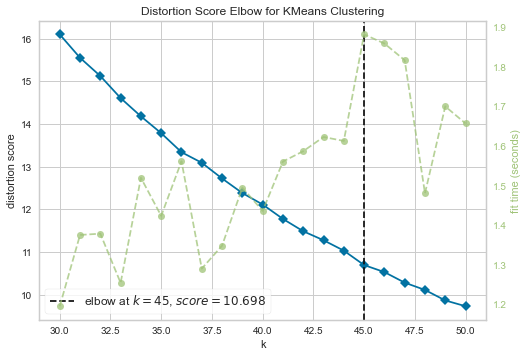

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [73]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(30, 51))

visualizer.fit(tfidf_features_reduced)        
visualizer.show()        

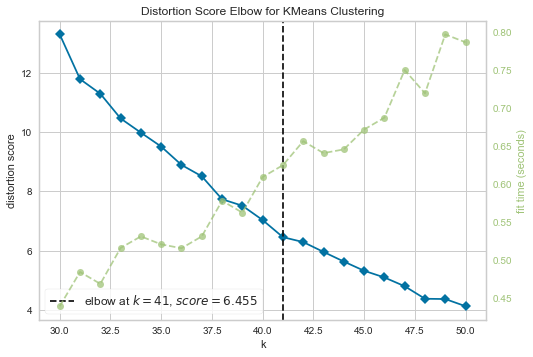

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [74]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(30, 51))

visualizer.fit(doc2vec_features_reduced)        
visualizer.show()        

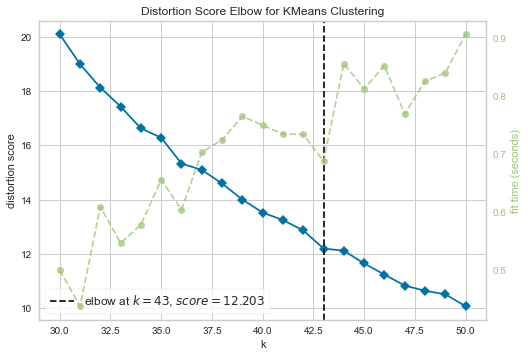

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [75]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(30, 51))

visualizer.fit(tfidf_doc2vec_features_reduced)        
visualizer.show()        

### KMeans w/ TFIDF

In [76]:
kmeans_tfidf_model = KMeans(43, random_state=0)
kmeans_tfidf_clusters = kmeans_tfidf_model.fit_predict(tfidf_features_reduced)

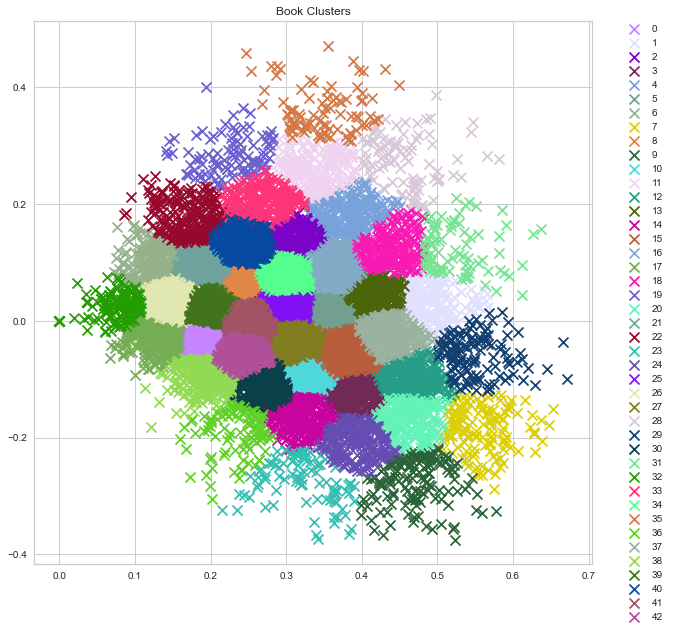

In [77]:
cluster_plotting(tfidf_features_reduced, kmeans_tfidf_clusters)

In [78]:
clustering_evaluation(tfidf_features_reduced, kmeans_tfidf_clusters)

Total Within Cluster Sum of Squares: 1.3316500985601714
Total Between Cluster Sum of Squares: 36.77996439774444
Cluster Consistency: 0.03620585610577252
Silhouette Coefficient: 0.32381363726864226



### KMeans w/ Doc2Vec

In [79]:
kmeans_doc2vec_model = KMeans(43, random_state=0)
kmeans_doc2vec_clusters = kmeans_doc2vec_model.fit_predict(doc2vec_features_reduced)

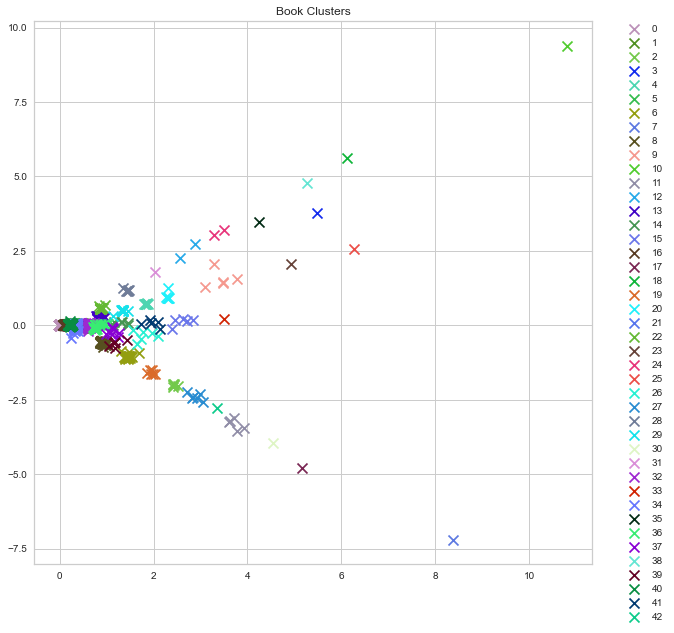

In [80]:
cluster_plotting(doc2vec_features_reduced, kmeans_doc2vec_clusters)

In [81]:
clustering_evaluation(doc2vec_features_reduced, kmeans_doc2vec_clusters)

Total Within Cluster Sum of Squares: 0.439802685752511
Total Between Cluster Sum of Squares: 249.30381245724857
Cluster Consistency: 0.001764123385910634
Silhouette Coefficient: 0.8659563064575195



### KMeans w/ TFIDF+Doc2Vec

In [82]:
kmeans_tfidf_doc2vec_model = KMeans(43, random_state=0)
kmeans_tfidf_doc2vec_clusters = kmeans_tfidf_doc2vec_model.fit_predict(tfidf_doc2vec_features_reduced)

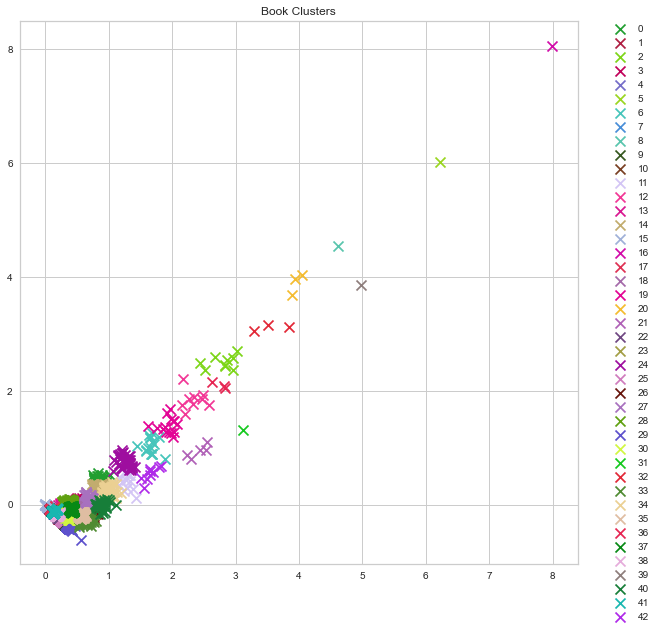

In [83]:
cluster_plotting(tfidf_doc2vec_features_reduced, kmeans_tfidf_doc2vec_clusters)

In [84]:
clustering_evaluation(tfidf_doc2vec_features_reduced, kmeans_tfidf_doc2vec_clusters)

Total Within Cluster Sum of Squares: 1.450331673920902
Total Between Cluster Sum of Squares: 207.20912557931723
Cluster Consistency: 0.006999361972432686
Silhouette Coefficient: 0.44673319318276744



### Gaussian Mixture w/ TFIDF

In [86]:
gm_tfidf = GaussianMixture(n_components=43, random_state=0)
gm_tfidf_labels = gm_tfidf.fit_predict(tfidf_features_reduced)

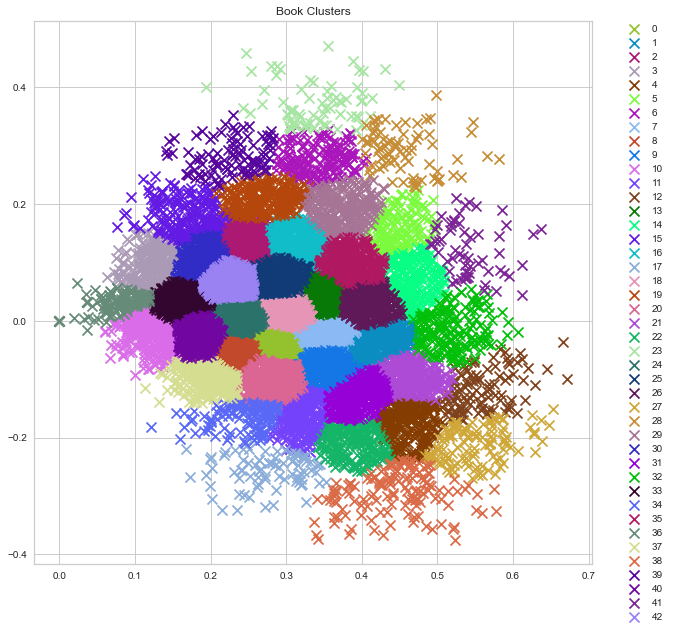

In [87]:
cluster_plotting(tfidf_features_reduced, gm_tfidf_labels)

In [88]:
clustering_evaluation(tfidf_features_reduced, gm_tfidf_labels)

Total Within Cluster Sum of Squares: 1.564847266539243
Total Between Cluster Sum of Squares: 38.831766821990236
Cluster Consistency: 0.04029812173400974
Silhouette Coefficient: 0.3156391263772797



### Gaussian Mixture w/ Doc2Vec

In [89]:
gm_doc2vec = GaussianMixture(n_components=43, random_state=0)
gm_doc2vec_labels = gm_doc2vec.fit_predict(doc2vec_features_reduced)

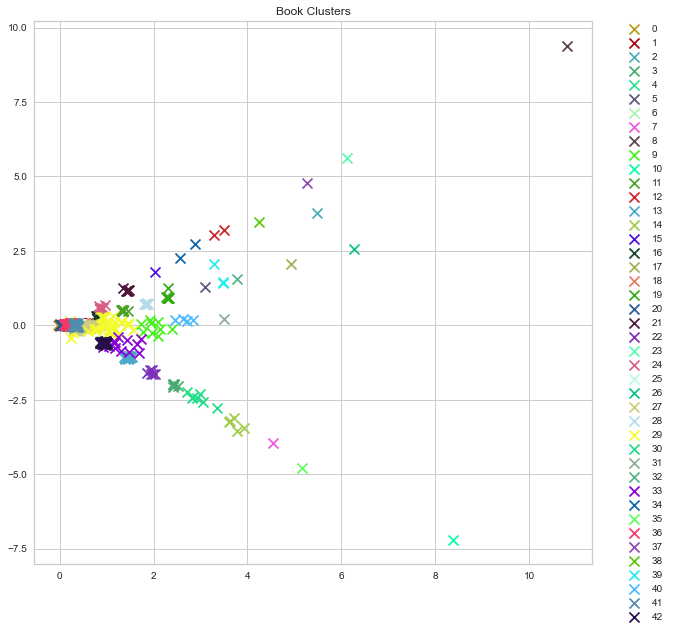

In [90]:
cluster_plotting(doc2vec_features_reduced, gm_doc2vec_labels)

In [91]:
clustering_evaluation(doc2vec_features_reduced, gm_doc2vec_labels)

Total Within Cluster Sum of Squares: 0.7991547137498856
Total Between Cluster Sum of Squares: 245.44462627917528
Cluster Consistency: 0.0032559470780220124
Silhouette Coefficient: 0.8208803534507751



### Gaussian Mixture w/ TFIDF+Doc2Vec

In [92]:
gm_tfidf_doc2vec = GaussianMixture(n_components=43, random_state=0)
gm_tfidf_doc2vec_labels = gm_doc2vec.fit_predict(tfidf_doc2vec_features_reduced)

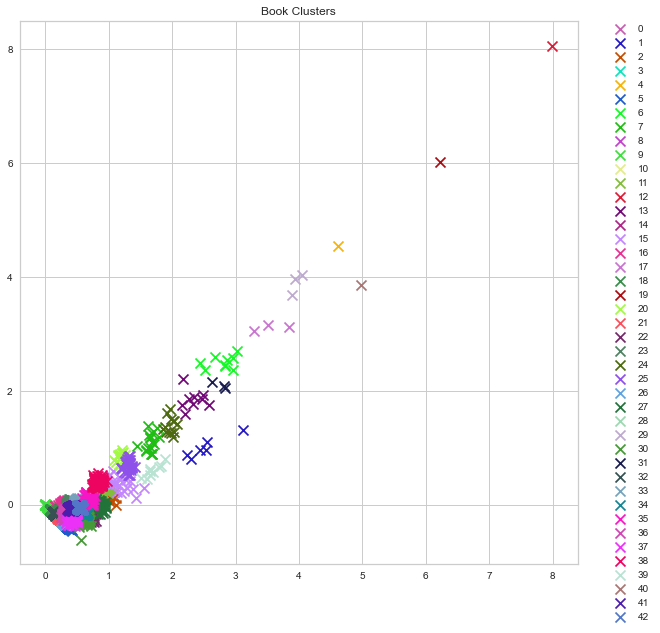

In [93]:
cluster_plotting(tfidf_doc2vec_features_reduced, gm_tfidf_doc2vec_labels)

In [94]:
clustering_evaluation(tfidf_doc2vec_features_reduced, gm_tfidf_doc2vec_labels)

Total Within Cluster Sum of Squares: 1.5122104729747257
Total Between Cluster Sum of Squares: 126.44117750835582
Cluster Consistency: 0.01195979429149805
Silhouette Coefficient: 0.4473184791765868



In [99]:
tfidf_features_reduced_ = pd.DataFrame(tfidf_features_reduced)

In [100]:
doc2vec_features_reduced_ = pd.DataFrame(doc2vec_features_reduced)

In [101]:
tfidf_doc2vec_features_reduced_ = pd.DataFrame(tfidf_doc2vec_features_reduced)

In [373]:
def recommend(model, features, cluster_labels, book):
    found = False

    for title in dataset["Book title"]:
        if fuzz.WRatio(book, title) > 80:
            found = True
            book = title
            break
            
    if found:
        index = int(dataset.loc[dataset["Book title"] == book].index[0])
        cluster = cluster_labels[index]
        
#     else:
#         book_summary = scrape_book_summary(book)
#         cleaned_book_summary = cleaned_text(book_summary)
#         features = extract_features(cleaned_book_summary)
#         cluster = model.predict(features)
        
    cosine_scores = cosine_similarity(features[cluster_labels == cluster])
    cosine_scores = pd.DataFrame(cosine_scores, columns=features[cluster_labels == cluster].index)
    
    if int(features[cluster_labels == cluster].count()[0]) >= 3:
        rec_indices = list(cosine_scores[index].nlargest(4).index)
        rec_scores = list(cosine_scores[index].nlargest(4))
       
    elif int(features[cluster_labels == cluster].count()[0]) == 2:
        rec_indices = list(cosine_scores[index].nlargest(2).index)
        rec_scores = list(cosine_scores[index].nlargest(2))
        
    else: 
        rec_indices = index
        rec_scores = list(cosine_scores[index].nlargest(1))
        
    return index, rec_indices, rec_scores, list(dataset.iloc[rec_indices]["Book title"]), list(dataset.iloc[rec_indices]["Book author"])

In [382]:
 _, _, _, recommendations, authors = recommend(kmeans_doc2vec_model, doc2vec_features_reduced_, kmeans_doc2vec_clusters, "Poor Folk")

In [383]:
recommendations

['1632',
 'The Deep Blue Good-by',
 'Right Ho, Jeeves',
 'The Great War: Walk in Hell']

# Evaluation

In [411]:
books = ["The Last Command"]
book_indices= [int(dataset.loc[dataset["Book title"] == books[0]].index[0])]

In [412]:
rec_indices_ = []
rec_scores_ = []
recommendations_ = []

for book in books:
    index, rec_indices, rec_scores, recommendations, authors = recommend(kmeans_doc2vec_model, doc2vec_features_reduced_, kmeans_doc2vec_clusters, book)
    rec_indices_.append(rec_indices)
    rec_scores_.append(rec_scores)
    recommendations_.append(recommendations)

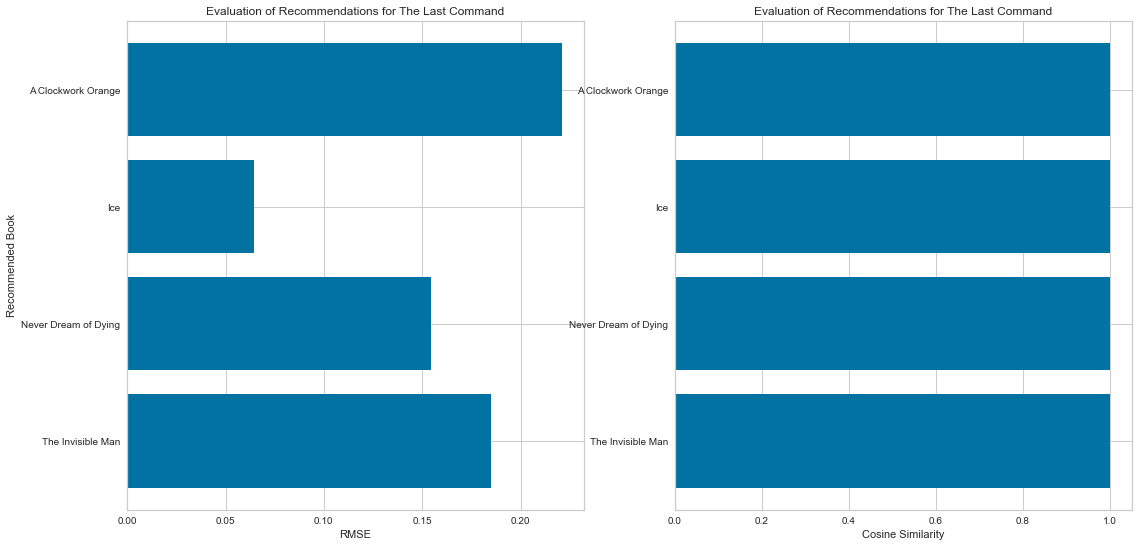

In [413]:
for ind, book in enumerate(books):
    rmse_values = []
    for rec in rec_indices_[ind]:
        rmse = mean_squared_error(tfidf_features_reduced_.iloc[book_indices[ind]], tfidf_features_reduced_.iloc[rec], squared=False)
        rmse_values.append(rmse)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 9)
    ax1.barh(recommendations_[ind], rmse_values)
    ax1.set_ylabel("Recommended Book")
    ax1.set_xlabel("RMSE")
    ax1.set_title("Evaluation of Recommendations for {}".format(book))
    
    ax2.barh(recommendations_[ind], rec_scores_[ind])
#     ax2.set_ylabel("Recommended Book")
    ax2.set_xlabel("Cosine Similarity")
    ax2.set_title("Evaluation of Recommendations for {}".format(book))

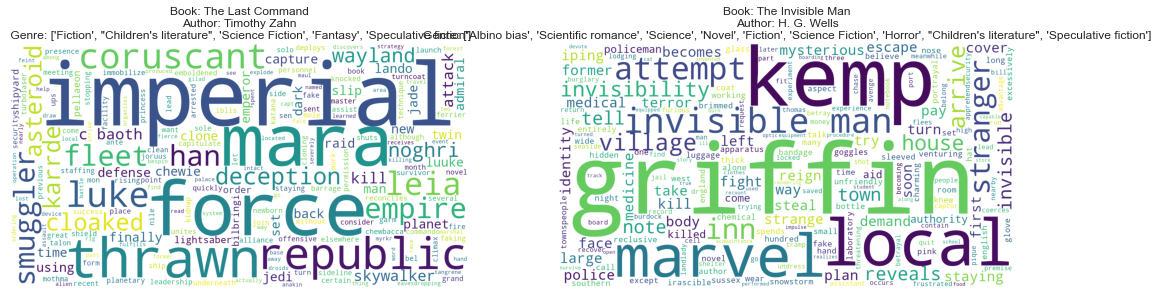

In [414]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 9)

book_a = dataset.iloc[book_indices[0]]["Summary"]
ax1.set_title("Book: {0}\nAuthor: {1}\n Genre: {2}".format(dataset.iloc[book_indices[0]]["Book title"], dataset.iloc[book_indices[0]]["Book author"], list(dataset.iloc[book_indices[0]]["Genre"])))
wordcloud = WordCloud(width = 1500, height = 800, background_color ='white', min_font_size = 10).generate(book_a)
ax1.axis('off')
ax1.imshow(wordcloud)

book_b = dataset.iloc[rec_indices_[0][0]]["Summary"]
ax2.set_title("Book: {0}\nAuthor: {1}\nGenre: {2}".format(dataset.iloc[rec_indices_[0][0]]["Book title"], dataset.iloc[rec_indices_[0][0]]["Book author"], list(dataset.iloc[rec_indices_[0][0]]["Genre"])))
wordcloud = WordCloud(width = 1500, height = 800, background_color ='white', min_font_size = 10).generate(book_b)
ax2.axis('off')
ax2.imshow(wordcloud)

Text(0.5, 1.0, 'Book: The Last Command\nAuthor: Timothy Zahn')

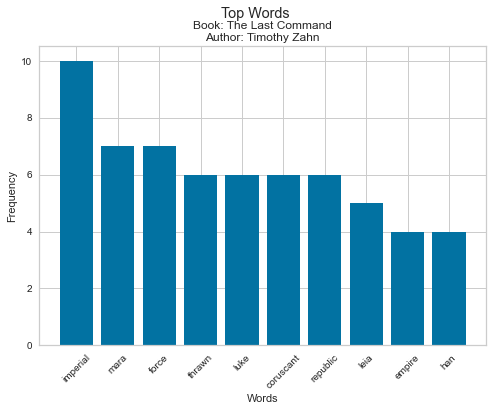

In [415]:
tokens = dataset.iloc[book_indices[0]]["Summary"].split()
unique_words = set(tokens)

word_freqs = {word: tokens.count(word) for word in unique_words}
sorted_word_freqs = {k: v for k, v in sorted(word_freqs.items(), key=lambda item: item[1], reverse=True)[:10]}

plt.bar(sorted_word_freqs.keys(),sorted_word_freqs.values())
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.suptitle("Top Words")
plt.title("Book: {0}\nAuthor: {1}".format(dataset.iloc[book_indices[0]]["Book title"], dataset.iloc[book_indices[0]]["Book author"]))

Text(0.5, 1.0, 'Book: The Invisible Man\nAuthor: H. G. Wells')

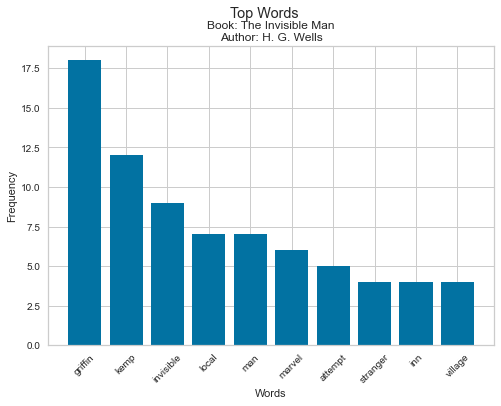

In [416]:
tokens = dataset.iloc[rec_indices_[0][0]]["Summary"].split()
unique_words = set(tokens)

word_freqs = {word: tokens.count(word) for word in unique_words}
sorted_word_freqs = {k: v for k, v in sorted(word_freqs.items(), key=lambda item: item[1], reverse=True)[:10]}

plt.bar(sorted_word_freqs.keys(),sorted_word_freqs.values())
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.suptitle("Top Words")
plt.title("Book: {0}\nAuthor: {1}".format(dataset.iloc[rec_indices_[0][0]]["Book title"], dataset.iloc[rec_indices_[0][0]]["Book author"]))

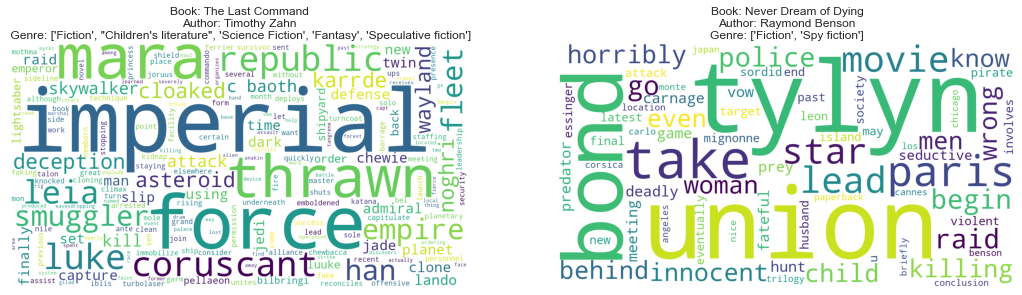

In [417]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 9)

book_a = dataset.iloc[book_indices[0]]["Summary"]
ax1.set_title("Book: {0}\nAuthor: {1}\n Genre: {2}".format(dataset.iloc[book_indices[0]]["Book title"], dataset.iloc[book_indices[0]]["Book author"], list(dataset.iloc[book_indices[0]]["Genre"])))
wordcloud = WordCloud(width = 1500, height = 800, background_color ='white', min_font_size = 10).generate(book_a)
ax1.axis('off')
ax1.imshow(wordcloud)

book_b = dataset.iloc[rec_indices_[0][1]]["Summary"]
ax2.set_title("Book: {0}\nAuthor: {1}\nGenre: {2}".format(dataset.iloc[rec_indices_[0][1]]["Book title"], dataset.iloc[rec_indices_[0][1]]["Book author"], list(dataset.iloc[rec_indices_[0][1]]["Genre"])))
wordcloud = WordCloud(width = 1500, height = 800, background_color ='white', min_font_size = 10).generate(book_b)
ax2.axis('off')
ax2.imshow(wordcloud)

Text(0.5, 1.0, 'Book: Never Dream of Dying\nAuthor: Raymond Benson')

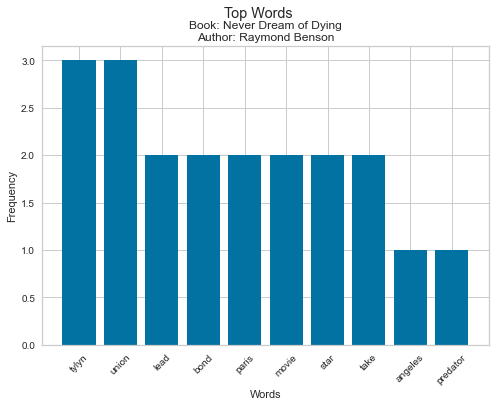

In [419]:
tokens = dataset.iloc[rec_indices_[0][1]]["Summary"].split()
unique_words = set(tokens)

word_freqs = {word: tokens.count(word) for word in unique_words}
sorted_word_freqs = {k: v for k, v in sorted(word_freqs.items(), key=lambda item: item[1], reverse=True)[:10]}

plt.bar(sorted_word_freqs.keys(),sorted_word_freqs.values())
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.suptitle("Top Words")
plt.title("Book: {0}\nAuthor: {1}".format(dataset.iloc[rec_indices_[0][1]]["Book title"], dataset.iloc[rec_indices_[0][1]]["Book author"]))

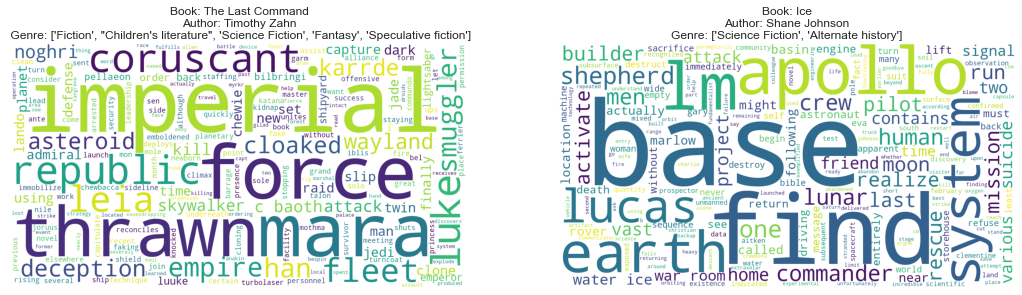

In [420]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 9)

book_a = dataset.iloc[book_indices[0]]["Summary"]
ax1.set_title("Book: {0}\nAuthor: {1}\n Genre: {2}".format(dataset.iloc[book_indices[0]]["Book title"], dataset.iloc[book_indices[0]]["Book author"], list(dataset.iloc[book_indices[0]]["Genre"])))
wordcloud = WordCloud(width = 1500, height = 800, background_color ='white', min_font_size = 10).generate(book_a)
ax1.axis('off')
ax1.imshow(wordcloud)

book_b = dataset.iloc[rec_indices_[0][2]]["Summary"]
ax2.set_title("Book: {0}\nAuthor: {1}\nGenre: {2}".format(dataset.iloc[rec_indices_[0][2]]["Book title"], dataset.iloc[rec_indices_[0][2]]["Book author"], list(dataset.iloc[rec_indices_[0][2]]["Genre"])))
wordcloud = WordCloud(width = 1500, height = 800, background_color ='white', min_font_size = 10).generate(book_b)
ax2.axis('off')
ax2.imshow(wordcloud)

Text(0.5, 1.0, 'Book: Ice\nAuthor: Shane Johnson')

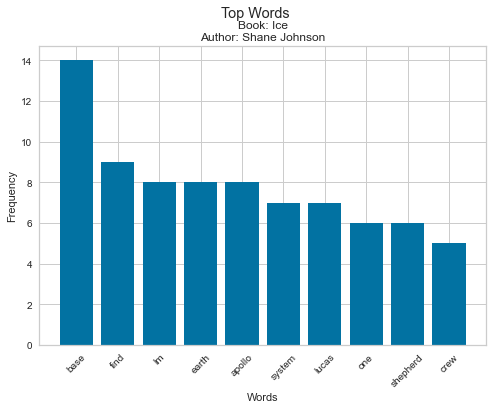

In [421]:
tokens = dataset.iloc[rec_indices_[0][2]]["Summary"].split()
unique_words = set(tokens)

word_freqs = {word: tokens.count(word) for word in unique_words}
sorted_word_freqs = {k: v for k, v in sorted(word_freqs.items(), key=lambda item: item[1], reverse=True)[:10]}

plt.bar(sorted_word_freqs.keys(),sorted_word_freqs.values())
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.suptitle("Top Words")
plt.title("Book: {0}\nAuthor: {1}".format(dataset.iloc[rec_indices_[0][2]]["Book title"], dataset.iloc[rec_indices_[0][2]]["Book author"]))

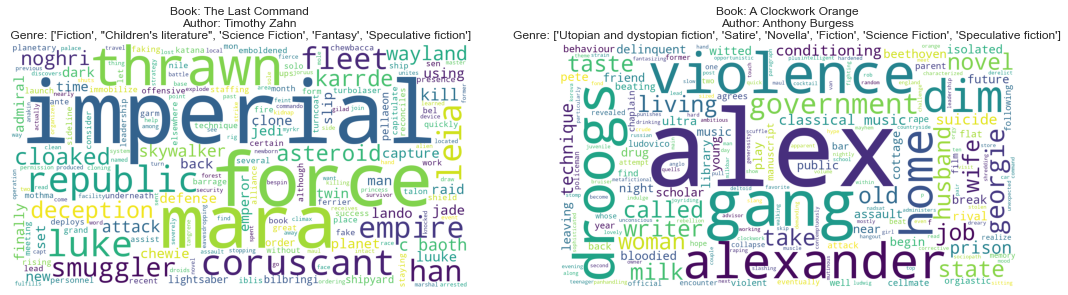

In [422]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 9)

book_a = dataset.iloc[book_indices[0]]["Summary"]
ax1.set_title("Book: {0}\nAuthor: {1}\n Genre: {2}".format(dataset.iloc[book_indices[0]]["Book title"], dataset.iloc[book_indices[0]]["Book author"], list(dataset.iloc[book_indices[0]]["Genre"])))
wordcloud = WordCloud(width = 1500, height = 800, background_color ='white', min_font_size = 10).generate(book_a)
ax1.axis('off')
ax1.imshow(wordcloud)

book_b = dataset.iloc[rec_indices_[0][3]]["Summary"]
ax2.set_title("Book: {0}\nAuthor: {1}\nGenre: {2}".format(dataset.iloc[rec_indices_[0][3]]["Book title"], dataset.iloc[rec_indices_[0][3]]["Book author"], list(dataset.iloc[rec_indices_[0][3]]["Genre"])))
wordcloud = WordCloud(width = 1500, height = 800, background_color ='white', min_font_size = 10).generate(book_b)
ax2.axis('off')
ax2.imshow(wordcloud)

Text(0.5, 1.0, 'Book: A Clockwork Orange\nAuthor: Anthony Burgess')

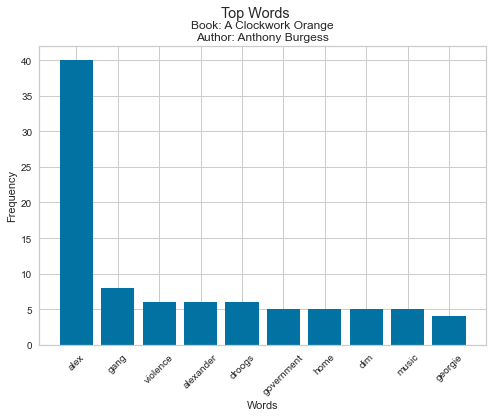

In [423]:
tokens = dataset.iloc[rec_indices_[0][3]]["Summary"].split()
unique_words = set(tokens)

word_freqs = {word: tokens.count(word) for word in unique_words}
sorted_word_freqs = {k: v for k, v in sorted(word_freqs.items(), key=lambda item: item[1], reverse=True)[:10]}

plt.bar(sorted_word_freqs.keys(),sorted_word_freqs.values())
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.suptitle("Top Words")
plt.title("Book: {0}\nAuthor: {1}".format(dataset.iloc[rec_indices_[0][3]]["Book title"], dataset.iloc[rec_indices_[0][3]]["Book author"]))

# Classification

In [230]:
new_dataset = dataset.copy()
temp_list = []
for i in new_dataset['Genre']:
    x = len(temp_list)
    for j in i:
        if 'fiction' in j.lower():
            temp_list.append('Fiction')
            break
    if x == len(temp_list):
        temp_list.append('Non Fiction')

In [234]:
new_dataset['Genre'] = temp_list
new_dataset

,Book title,Book author,Genre,Summary
0,Animal Farm,George Orwell,Fiction,old major old boar manor farm call animal farm...
1,A Clockwork Orange,Anthony Burgess,Fiction,alex teenager living near future england lead ...
2,The Plague,Albert Camus,Fiction,text plague divided five part town oran thousa...
3,A Fire Upon the Deep,Vernor Vinge,Fiction,novel posit space around milky way divided con...
4,All Quiet on the Western Front,Erich Maria Remarque,Non Fiction,book tell story paul b umer german soldier urg...
...,...,...,...,...
12050,The Third Lynx,Timothy Zahn,Fiction,story start former government agent frank comp...
12051,Remote Control,Andy McNab,Fiction,series follows character nick stone ex militar...
12052,Transfer of Power,Vince Flynn,Fiction,reader first meet rapp covert operation iran d...
12053,Decoded,Jay-Z,Non Fiction,book follows rough chronological order switchi...


In [250]:
xtrain, xtest, ytrain, ytest = train_test_split(new_dataset['Summary'], new_dataset['Genre'], test_size = 0.3, stratify=new_dataset['Genre'], random_state=0)
xtrain = xtrain.reset_index(drop = True)
xtest = xtest.reset_index(drop = True)

### BoW

In [285]:
bow_vectorizer = CountVectorizer()
bow_train_model = bow_vectorizer.fit_transform(xtrain)
bow_features_train = pd.DataFrame(bow_train_model.toarray(), columns = bow_vectorizer.get_feature_names())

bow_test_model = bow_vectorizer.transform(xtest)
bow_features_test = pd.DataFrame(bow_test_model.toarray(), columns = bow_vectorizer.get_feature_names())

### TFIDF

In [254]:
tfIdf_vectorizer = TfidfVectorizer(use_idf=True, min_df=0.05)
tfidf_train_model = tfIdf_vectorizer.fit_transform(xtrain)
tfidf_features_train = pd.DataFrame(tfidf_train_model.toarray(), columns = tfIdf_vectorizer.get_feature_names())

tfidf_test_model = tfIdf_vectorizer.transform(xtest)
tfidf_features_test = pd.DataFrame(tfidf_test_model.toarray(), columns = tfIdf_vectorizer.get_feature_names())

### Doc2Vec

In [255]:
documents = [doc for doc in xtrain]
doc2vec_train = [TaggedDocument(tokens, [i]) for i, tokens in enumerate(documents)]
doc2vec_test = [doc for doc in xtest]

doc2vec_model = Doc2Vec(vector_size=300, min_count=2, epochs=40)
doc2vec_model.build_vocab(doc2vec_train)
doc2vec_model.train(doc2vec_train, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

doc2vec_features_train = [doc2vec_model.infer_vector(doc.split()) for doc in documents]
doc2vec_features_train = np.array(doc2vec_features_train)

doc2vec_features_test = [doc2vec_model.infer_vector(doc.split()) for doc in doc2vec_test]
doc2vec_features_test = np.array(doc2vec_features_test)

In [256]:
doc2vec_features_train = pd.DataFrame(doc2vec_features_train)
doc2vec_features_test = pd.DataFrame(doc2vec_features_test)

### TFIDF + Doc2Vec

In [257]:
tfidf_doc2vec_features_train = pd.concat([tfidf_features_train, doc2vec_features_train], axis=1)
tfidf_doc2vec_features_test = pd.concat([tfidf_features_test, doc2vec_features_test], axis=1)

### SVM w/ TFIDF

72.3251313243019
              precision    recall  f1-score   support

     Fiction       0.72      1.00      0.84      2616
 Non Fiction       0.00      0.00      0.00      1001

    accuracy                           0.72      3617
   macro avg       0.36      0.50      0.42      3617
weighted avg       0.52      0.72      0.61      3617



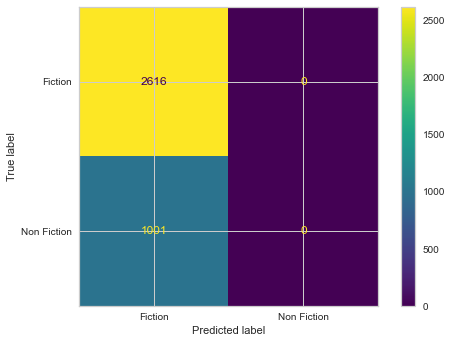

In [280]:
svm_model = SVC(kernel="poly", gamma='auto', random_state=0)
svm_model.fit(tfidf_features_train, ytrain)
ypred = svm_model.predict(tfidf_features_test)
print(accuracy_score(ytest, ypred)*100)
print(classification_report(ytest, ypred))
plot_confusion_matrix(svm_model, tfidf_features_test, ytest)

### SVM w/ Doc2Vec

72.3251313243019
              precision    recall  f1-score   support

     Fiction       0.72      1.00      0.84      2616
 Non Fiction       0.00      0.00      0.00      1001

    accuracy                           0.72      3617
   macro avg       0.36      0.50      0.42      3617
weighted avg       0.52      0.72      0.61      3617



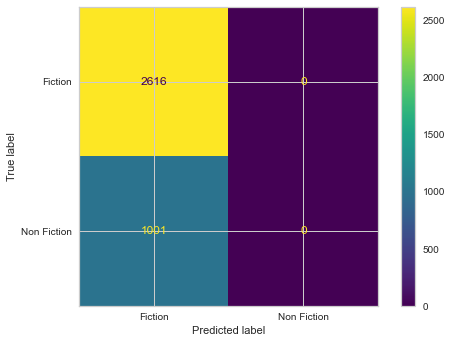

In [269]:
svm_model1 = SVC(kernel="poly", gamma='auto', random_state=0)
svm_model1.fit(doc2vec_features_train, ytrain)
ypred = svm_model1.predict(doc2vec_features_test)
print(accuracy_score(ytest, ypred)*100)
print(classification_report(ytest, ypred))
plot_confusion_matrix(svm_model1, doc2vec_features_test, ytest)

### SVM w/ TFIDF+Doc2Vec

72.3251313243019
              precision    recall  f1-score   support

     Fiction       0.72      1.00      0.84      2616
 Non Fiction       0.00      0.00      0.00      1001

    accuracy                           0.72      3617
   macro avg       0.36      0.50      0.42      3617
weighted avg       0.52      0.72      0.61      3617



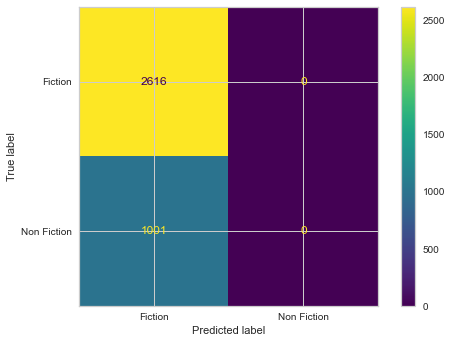

In [270]:
svm_model2 = SVC(kernel="poly", gamma='auto', random_state=0)
svm_model2.fit(tfidf_doc2vec_features_train, ytrain)
ypred = svm_model2.predict(tfidf_doc2vec_features_test)
print(accuracy_score(ytest, ypred)*100)
print(classification_report(ytest, ypred))
plot_confusion_matrix(svm_model2, tfidf_doc2vec_features_test, ytest)

### Gaussian Naive Bayes w/ TFIDF

62.81448714404202
              precision    recall  f1-score   support

     Fiction       0.82      0.62      0.71      2616
 Non Fiction       0.40      0.65      0.49      1001

    accuracy                           0.63      3617
   macro avg       0.61      0.63      0.60      3617
weighted avg       0.70      0.63      0.65      3617



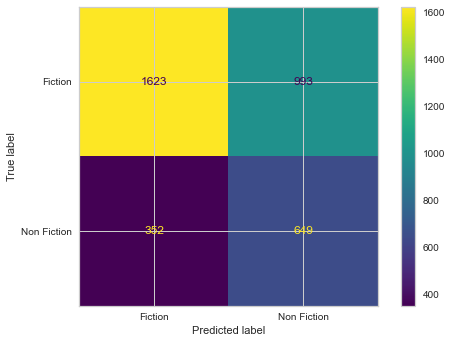

In [288]:
gnb_model = GaussianNB()
gnb_model.fit(tfidf_features_train, ytrain)
ypred_f = gnb_model.predict(tfidf_features_test)
print(accuracy_score(ytest, ypred_f)*100)
print(classification_report(ytest, ypred_f))
plot_confusion_matrix(gnb_model, tfidf_features_test, ytest)

### Gaussian Naive Bayes w/ Doc2Vec

32.48548520873652
              precision    recall  f1-score   support

     Fiction       0.79      0.09      0.16      2616
 Non Fiction       0.28      0.94      0.43      1001

    accuracy                           0.32      3617
   macro avg       0.54      0.51      0.30      3617
weighted avg       0.65      0.32      0.24      3617



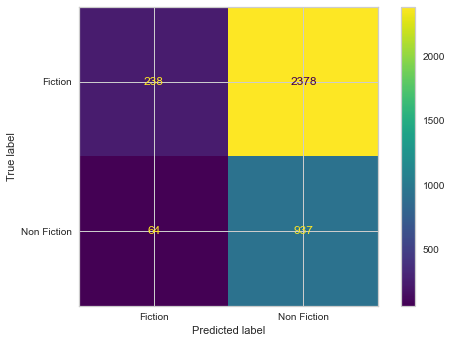

In [275]:
gnb_model1 = GaussianNB()
gnb_model1.fit(doc2vec_features_train, ytrain)
ypred = gnb_model1.predict(doc2vec_features_test)
print(accuracy_score(ytest, ypred)*100)
print(classification_report(ytest, ypred))
plot_confusion_matrix(gnb_model1, doc2vec_features_test, ytest)

### Gaussian Naive Bayes w/ TFIDF+Doc2Vec

58.805640033176665
              precision    recall  f1-score   support

     Fiction       0.84      0.53      0.65      2616
 Non Fiction       0.37      0.73      0.49      1001

    accuracy                           0.59      3617
   macro avg       0.61      0.63      0.57      3617
weighted avg       0.71      0.59      0.61      3617



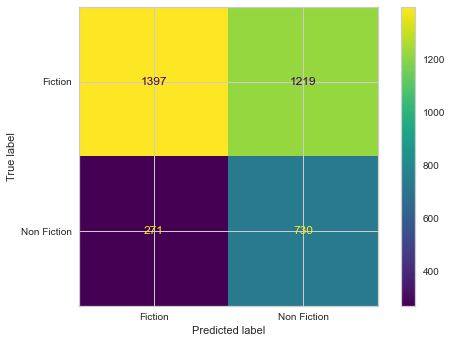

In [277]:
gnb_model2 = GaussianNB()
gnb_model2.fit(tfidf_doc2vec_features_train, ytrain)
ypred = gnb_model2.predict(tfidf_doc2vec_features_test)
print(accuracy_score(ytest, ypred)*100)
print(classification_report(ytest, ypred))
plot_confusion_matrix(gnb_model2, tfidf_doc2vec_features_test, ytest)

### Decision Tree w/ TFIDF

63.45037323748963
              precision    recall  f1-score   support

     Fiction       0.75      0.75      0.75      2616
 Non Fiction       0.34      0.33      0.33      1001

    accuracy                           0.63      3617
   macro avg       0.54      0.54      0.54      3617
weighted avg       0.63      0.63      0.63      3617



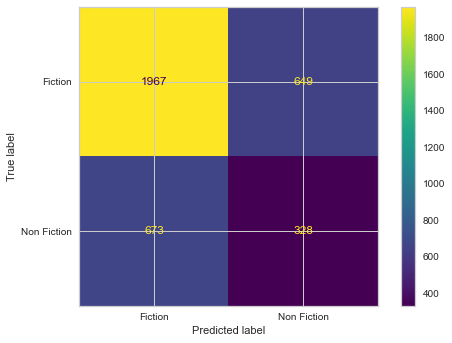

In [283]:
dt_model = DecisionTreeClassifier(criterion="entropy", random_state=0)
dt_model.fit(tfidf_features_train, ytrain)
ypred = dt_model.predict(tfidf_features_test)
print(accuracy_score(ytest, ypred)*100)
print(classification_report(ytest, ypred))
plot_confusion_matrix(dt_model, tfidf_features_test, ytest)

### Decision Tree w/ Doc2Vec

59.60740945534974
              precision    recall  f1-score   support

     Fiction       0.72      0.72      0.72      2616
 Non Fiction       0.28      0.28      0.28      1001

    accuracy                           0.60      3617
   macro avg       0.50      0.50      0.50      3617
weighted avg       0.60      0.60      0.60      3617



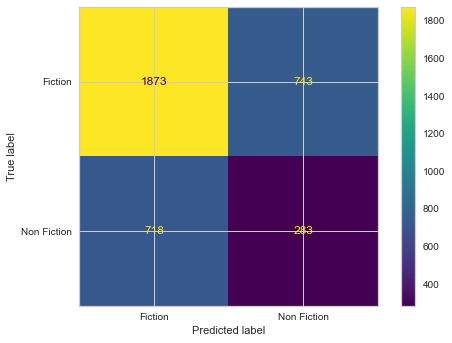

In [282]:
dt_model1 = DecisionTreeClassifier(criterion="entropy", random_state=0)
dt_model1.fit(doc2vec_features_train, ytrain)
ypred = dt_model1.predict(doc2vec_features_test)
print(accuracy_score(ytest, ypred)*100)
print(classification_report(ytest, ypred))
plot_confusion_matrix(dt_model1, doc2vec_features_test, ytest)

### Decision Tree w/ TFIDF+Doc2Vec

63.11860658003871
              precision    recall  f1-score   support

     Fiction       0.75      0.74      0.74      2616
 Non Fiction       0.34      0.34      0.34      1001

    accuracy                           0.63      3617
   macro avg       0.54      0.54      0.54      3617
weighted avg       0.63      0.63      0.63      3617



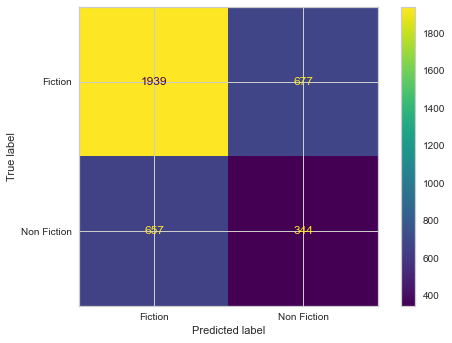

In [281]:
dt_model2 = DecisionTreeClassifier(criterion="entropy",random_state=0)
dt_model2.fit(tfidf_doc2vec_features_train, ytrain)
ypred = dt_model2.predict(tfidf_doc2vec_features_test)
print(accuracy_score(ytest, ypred)*100)
print(classification_report(ytest, ypred))
plot_confusion_matrix(dt_model2, tfidf_doc2vec_features_test, ytest)

# Recommender Interface

In [299]:
def predict_genre(book):
    found = False

    for title in dataset["Book title"]:
        if fuzz.WRatio(book, title) > 80:
            found = True
            book = title
            break
            
    if found:
        summary = dataset.loc[dataset["Book title"] == book]["Summary"]
        features = tfIdf_vectorizer.transform(summary)
        genre = gnb_model.predict(features.toarray())[0]
        
    return genre

In [429]:
app = Flask(__name__)

@app.route('/webhook', methods=['GET', 'POST'])
def webhook():
    req = request.get_json(silent=True, force=True)
    fulfilmentText = ""
    query_result = req.get('queryResult')
    book = query_result.get('parameters').get('book')
    genre = predict_genre(book)
    fulfillmentText = "Oh so you're interested in {} books! I know just the perfect books for you! ".format(genre)
    _, _, _, recommendations, authors = recommend(kmeans_doc2vec_model, doc2vec_features_reduced_, kmeans_doc2vec_clusters, book)
    if len(recommendations) >= 3:
        fulfillmentText += "According to your preference, you might also like: {} by {}, {} by {}, {} by {}, and {} by {}".format(recommendations[0], authors[0], recommendations[1], authors[1], recommendations[2],  authors[2], recommendations[3],  authors[3]) 
    elif len(recommendations) == 2:
        fulfillmentText += "According to your preference, you might also like: {} by {} and {} by {}".format(recommendations[0], authors[0], recommendations[1], authors[1]) 
    else:
        fulfillmentText += "Sorry, I have no recommendation similar to {} by {}".format(recommendations[0], authors[0]) 
    
    return {
        "fulfillmentText": fulfillmentText,
        "source": "webhookdata"
    }

In [ ]:
if __name__ == '__main__':
    app.run(host="0.0.0.0", port=5000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.1.19:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Dec/2021 14:35:19] "POST /webhook HTTP/1.1" 200 -
127.0.0.1 - - [05/Dec/2021 14:35:52] "POST /webhook HTTP/1.1" 200 -
127.0.0.1 - - [05/Dec/2021 14:38:18] "POST /webhook HTTP/1.1" 200 -
127.0.0.1 - - [05/Dec/2021 14:39:09] "POST /webhook HTTP/1.1" 200 -
127.0.0.1 - - [05/Dec/2021 14:39:52] "POST /webhook HTTP/1.1" 200 -
127.0.0.1 - - [05/Dec/2021 14:40:33] "POST /webhook HTTP/1.1" 200 -
127.0.0.1 - - [05/Dec/2021 14:49:15] "POST /webhook HTTP/1.1" 200 -
